# **MNIST**

In [1]:
from sklearn.datasets import fetch_openml
import pprint
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
import numpy as np
import pandas as pd

In [2]:
# Fetching the data.
mnist = fetch_openml('mnist_784')

In [3]:
# Converting into a dataframe.
# mnist_df = pd.DataFrame(data=mnist['data'], columns=mnist['feature_names'])
# mnist_df.to_excel('./data/mnist.xlsx', index=False)

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
# This function shows how a digit ie. the collection of pixel intensities looks like.
def see_a_digit(data, label, some_digit):
    # some_digit = random.randint(0, data.shape[0])
    some_digit_data = data[some_digit]
    some_digit_image = some_digit_data.reshape(28,28)
    plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    print('The number is: ', label[some_digit])
    plt.show()

The number is:  7


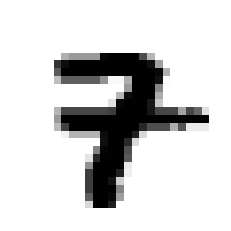

In [6]:
# To print a random number from the given data.
some_digit = random.randint(0, X.shape[0])
see_a_digit(X, y, some_digit)

We should always separate training set and test set before inspecting the data. The MNIST is already split into training and test set. First 60000 rows are meant for training, the remaining for test.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Here, shuffling the training set is important as it will make sure that the cross validation folds will be similar. Moreover, some of the learning algorithms are sensitive to the order of training instances.**

In [8]:
def shuffle_training_set(X_train, y_train):
    set_length = X_train.shape[0]
    shuffled_indexes = np.random.permutation(set_length)
    X_train, y_train = X_train[shuffled_indexes], y_train[shuffled_indexes]
    return X_train, y_train

In [9]:
# Shuffled training sets.
X_train, y_train = shuffle_training_set(X_train, y_train)

### **Training a Binary Classifier**

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([X[67974]])

array([ True])

### **Measuring Performance**

#### **1. Using Cross-Validation**

**(A) Self implementation**

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [15]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

/home/daywalker/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print("Going in")
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

Going in
0.8746
Going in
0.877
Going in
0.8628


**(B) Using cross_val_score function**

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9639, 0.9667, 0.965 ])

#### **2. Confusion Matrix**

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(y_train_5, y_train_pred)

array([[53993,   586],
       [ 1502,  3919]])

**Precision and Recall**

Precision: It is the measure of how accurately positive predictions are made. In this case, how accurate are we when we say its 5. Hence, precision = (True Positives) / (True Positives + False Positives)

Recall: It is the measure of true positive rate. In this case, how accurately we predict 5. Hence, Recall = True Positives / (True Positivies + False Negatives)

In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
precision_score(y_train_5, y_train_pred)

0.8699223085460599

In [25]:
recall_score(y_train_5, y_train_pred)

0.7229293488286294

**Precision/Recall tradeoff**

According to our need, we can decide whether we want a high recall or a high precision model. Unfortunately, both high recall and precision can't be achieved.

We can tweak the threshold to acheive the desired model. For this we will need *decision scores* instead of predictions.

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

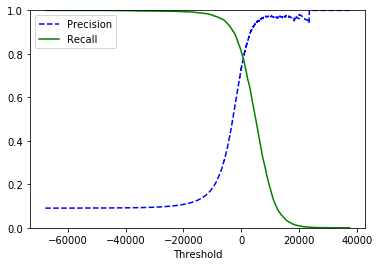

In [29]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_threshold(precisions, recalls, thresholds)
plt.show()

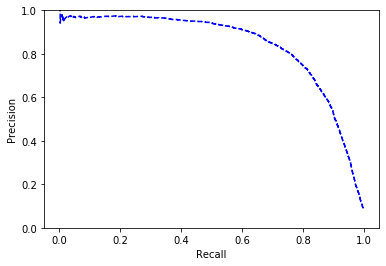

In [30]:
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1])
plot_precision_recall(precisions, recalls)
plt.show()

From the above two plots, we can choose a threshold of our choice.

In [31]:
# An example to check the precision and recall at threshold 70000.
threshold = 7000
y_train_pred_70k = (y_scores >= threshold)

# Precision.
precision_90 = precision_score(y_train_5, y_train_pred_70k)
print("Precision: ", precision_90)

# Recall.
recall_90 = recall_score(y_train_5, y_train_pred_70k)
print("Recall: ", recall_90)

Precision:  0.9634517766497462
Recall:  0.3501199040767386


#### **The ROC Curve**

ROC curve is obtained by plotting TPR(True positive rate) and FPR(False positive rate) at all thresholds. 

In [32]:
from sklearn.metrics import roc_curve

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

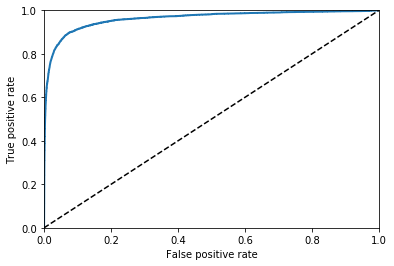

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Let's get the AUC.

In [35]:
from sklearn.metrics import roc_auc_score

In [36]:
roc_auc_score(y_train_5, y_scores)

0.9619949398585896

AUC can be used to compare the performance of algorithms. A perfect classifier would have an AUC = 1. A random classifier would have an AUC = 0.5.

Let's use a random forest classifier and compare it's AUC to SGDClassifier.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

But to plot an ROC curve, we need scores, not probabilities. Here, we can take the probability of positive class as the score.

In [39]:
y_scores_forest = y_probas_forest[:,1]

In [40]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

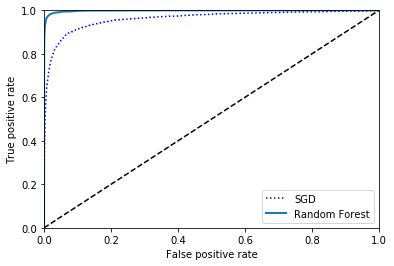

In [41]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983917715114827

In [43]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

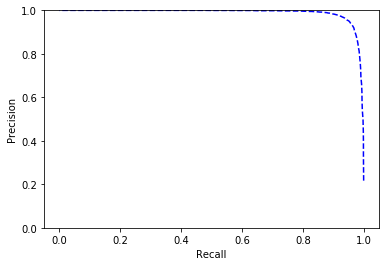

In [44]:
plot_precision_recall(precisions, recalls)

Random Forest Classifier performs way better than SGDClassifier.

### **Multiclass Classification**

Some classifiers are capable to distinguish between multiple classes. For example, RandomForestClassifier and Naive Bayes Classifier. Some are strictly binary. For example, SVM or linear classifiers.

However, we can use some strategies to use binary classifers for multiple class classification.

1. One-versus-rest or One-versus-all: We train as many classifiers as the number of classses. For any instance, the class having the highest score would be the class of the instance.

2. One-versus-one: We train one classifier for each pair of classes. Hence, if there are N classes, we will have N(N-1)/2 classifers. This is useful as the classifier need to be trained only on the classes they are meant to distinguish.

Sklearn detects when we are performing multiclass classification. It automatically uses the OVA approach.

In [45]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
sgd_clf.predict([X_train[some_digit]])

array(['6'], dtype='<U1')

To see the related scores with each class. We will have to call decision function.

In [47]:
# The decision score.
some_digit_sgd_scores = sgd_clf.decision_function([X_train[some_digit]])
print(some_digit_sgd_scores)

# Getting the index of the highest score.
print(np.argmax(some_digit_sgd_scores))

# Getting the classes.
print(sgd_clf.classes_)

# Getting the class which the number belongs to.
print(sgd_clf.classes_[np.argmax(some_digit_sgd_scores)])

[[-39635.88152613 -97823.05036863  -7453.0811958  -12434.04229766
  -25284.71810495 -15458.30715066  13139.00222154 -18594.18542527
  -16744.70892003 -24748.911756  ]]
6
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
6


Forcing sklearn to use OnevsOne strategy.

In [48]:
from sklearn.multiclass import OneVsOneClassifier

In [49]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X_train[some_digit]])

array(['6'], dtype=object)

For random forest we do not have to use OneVsOne or OneVsAll strategy as it can classify directly into multiple classes.

In [50]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [51]:
forest_clf.predict([X_train[some_digit]])

array(['6'], dtype=object)

To get a list of probabilities for different classes.

In [52]:
forest_clf.predict_proba([X_train[some_digit]])

array([[0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.96, 0.01, 0.01, 0.  ]])

Here we evaluate our classifiers.

In [53]:
# For SGDClassifier.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8828, 0.8542, 0.8771])

In [54]:
# For RandomForest Classifier.
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96635, 0.9658 , 0.96395])

To improve the performance let's scale our features.

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
print("SGD accuracy: ", cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))
print("RF accuracy: ", cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

/home/daywalker/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD accuracy:  [0.89445 0.90185 0.90035]
RF accuracy:  [0.96635 0.9659  0.96395]


Scaling improved results for SGDClassifier but not too much for Random Forest Classifier.

### **Error Analysis**

One way to analyze the classifier is to took at the confusion matrix. This will tell us where the classifier is finding it hard to make a prediction.

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

/home/daywalker/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [57]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5583,    0,   14,    6,    9,   37,   33,    5,  235,    1],
       [   0, 6412,   39,   22,    2,   47,    4,    8,  194,   14],
       [  23,   29, 5237,   86,   69,   27,   66,   41,  373,    7],
       [  23,   19,  120, 5208,    1,  216,   25,   42,  416,   61],
       [  11,   14,   39,    9, 5226,    6,   39,   18,  322,  158],
       [  27,   18,   28,  144,   51, 4480,   69,   16,  523,   65],
       [  26,   17,   44,    0,   42,   91, 5546,    3,  148,    1],
       [  18,   12,   56,   20,   56,   10,    5, 5697,  189,  202],
       [  15,   66,   43,   85,    2,  127,   28,    9, 5432,   44],
       [  25,   17,   27,   59,  127,   37,    1,  164,  380, 5112]])

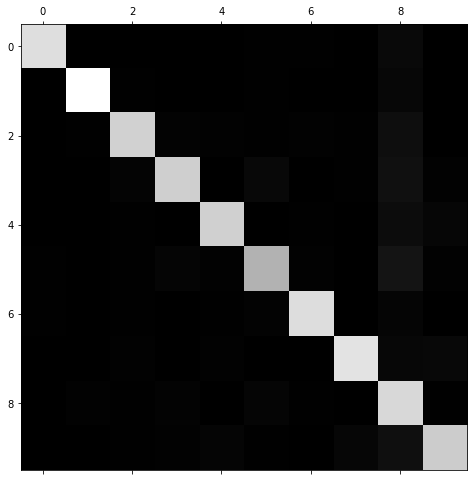

In [63]:
# Visualizing the confusion matrix.
plt.figure(figsize=(8, 8))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

Here, we look for the diagonal cells which are darker. These cells means one of the following things.
1.  The number of instances in the set are low.
2.  The classifier is finding it difficult to predict the respective class accurately.

In our case, it is the number 5.

Let's verify what case it is.

We will divide the confusion matrix numbers by the actual number of instances of a class.

In [68]:
rowsum = conf_mx.sum(axis=1, keepdims=True)
print(rowsum)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


From this, we know that the number of instances of 5 are not too low. This means that 5s are being confused with other numbers. Let's see what are those numbers.

In [73]:
conf_mx_ratio = conf_mx / rowsum

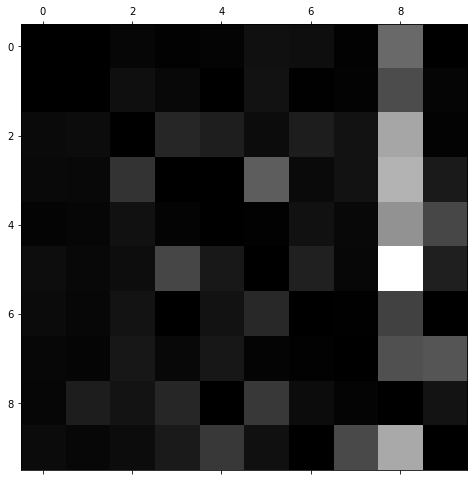

In [75]:
# Visualizing the ratios.
plt.figure(figsize=(8, 8))
np.fill_diagonal(conf_mx_ratio, 0)
plt.matshow(conf_mx_ratio, cmap=plt.cm.gray, fignum=1)
plt.show()

This looks good. Here, we can see that many digits are being confused with 8. If we look at the rows, 9s, 5s are light in color. 9s are being confused with 8. 5s are being 3 and 3s are being confused with 5. Latter ratio being much more. We have derived a few insights about our classifier.

There are possible solutions to solve this problem.
1. Collect more data points about these numbers so that the model improves.
2. Create a feature which captures a pattern due to which these numbers are being misclassified.

### **Multilabel Classification**

Sometimes we would like our classifer to output multiple classes for each instance. For example, a face-recognition classifier gives out multiple names of persons it finds in a group photo.

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
y_train = y_train.astype(int)
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

In [80]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [83]:
knn_clf = KNeighborsClassifier()

In [84]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [88]:
knn_clf.predict([X_train[some_digit]])

array([[False, False]])

This is true. 6 is neither a large number nor it is odd.

#### **Evaluating a multilabel classifier**

There are a few metrics we can choose to evaluate a multilabel classifier. Avg. F1 score is one of them. It takes the average of F1 scores of different labels.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score_avg = f1_score(y_multilabel, y_train_knn_pred, average='macro')

In [ ]:
# F1 score. Average.
f1_score_avg = f1_score(y_multilabel, y_train_knn_pred, average='macro')

If one label has to be given more importance than the other. We can use weighted average. More the number of instances of a particular class are present. More is the weightage.

In [ ]:
# F1 score. Weighted.
f1_score_weighted = f1_score(y_multilabel, y_train_knn_pred, average='weighted')